# Universidad de Buenos Aires
# Aprendizaje Profundo - TP2
# Cohorte 20 - 3er bimestre 2025


Este segundo TP se debe entregar hasta las **23hs del domingo 17 de agosto (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

ESTE TP2 EQUIVALE AL 40% DE SU NOTA FINAL.

El formato de entrega debe ser un link a un notebook de google colab. Permitir acceso a gvilcamiza.ext@fi.uba.ar y **habilitar los comentarios, para poder darles el feedback**. Si no lo hacen así no se podrá dar el feedback respectivo por cada pregunta.

El envío **se realizará en el siguiente link de google forms: [link](https://forms.gle/wgKVpFhX6F6Nfkf46)**. Tanto los resultados, gráficas, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**NO SE VALIDARÁN ENVÍOS POR CORREO, EL MÉTODO DE ENTREGA ES SOLO POR EL FORMS.**

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP2.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP2-Co20.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.
- Solo se revisarán los trabajos que hayan sido enviados por el forms.

# **CLASIFICADOR DE EMOCIONES**

El objetivo de este trabajo es construir una red neuronal convolucional (CNN) utilizando Pytorch, capaz de clasificar emociones humanas a partir de imágenes faciales. El clasificador deberá identificar una de las 7 emociones básicas: alegría, tristeza, enojo, miedo, sorpresa, disgusto y seriedad. El dataset se encuentra en este link: https://drive.google.com/file/d/1pGsz3NFVHOfDpFG3jvpuM4NtpDCv757Z/view?usp=sharing

## 1. Preprocesamiento de Datos (2 puntos)

Antes de entrenar el modelo, se debe analizar qué tipo de preprocesamiento se debe aplicar a las imágenes. Para esto, se puede considerar uno o más aspectos como:

- Tamaño
- Relación de aspecto
- Color o escala de grises
- Cambio de dimensionalidad
- Normalización
- Balanceo de datos
- Data augmentation
- etc.

Sean criteriosos y elijan solo las técnicas que consideren pertinentes para este caso de uso en específico.

Recomendación: usar `torchvision.transforms` para facilitar el preprocesamiento.



In [25]:
import os
from typing import Tuple, Callable, Optional
import supervision as sv
import cv2
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch import nn
import torch
import torchinfo
from torchvision.transforms import v2
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import (
    classification_report, 
    ConfusionMatrixDisplay, 
    accuracy_score,
    f1_score)
import numpy as np

Exploring folder: dataset_emociones/train/seriedad
Exploring folder: dataset_emociones/train/sorpresa
Exploring folder: dataset_emociones/train/disgusto
Exploring folder: dataset_emociones/train/tristeza
Exploring folder: dataset_emociones/train/miedo
Exploring folder: dataset_emociones/train/enojo
Exploring folder: dataset_emociones/train/alegria


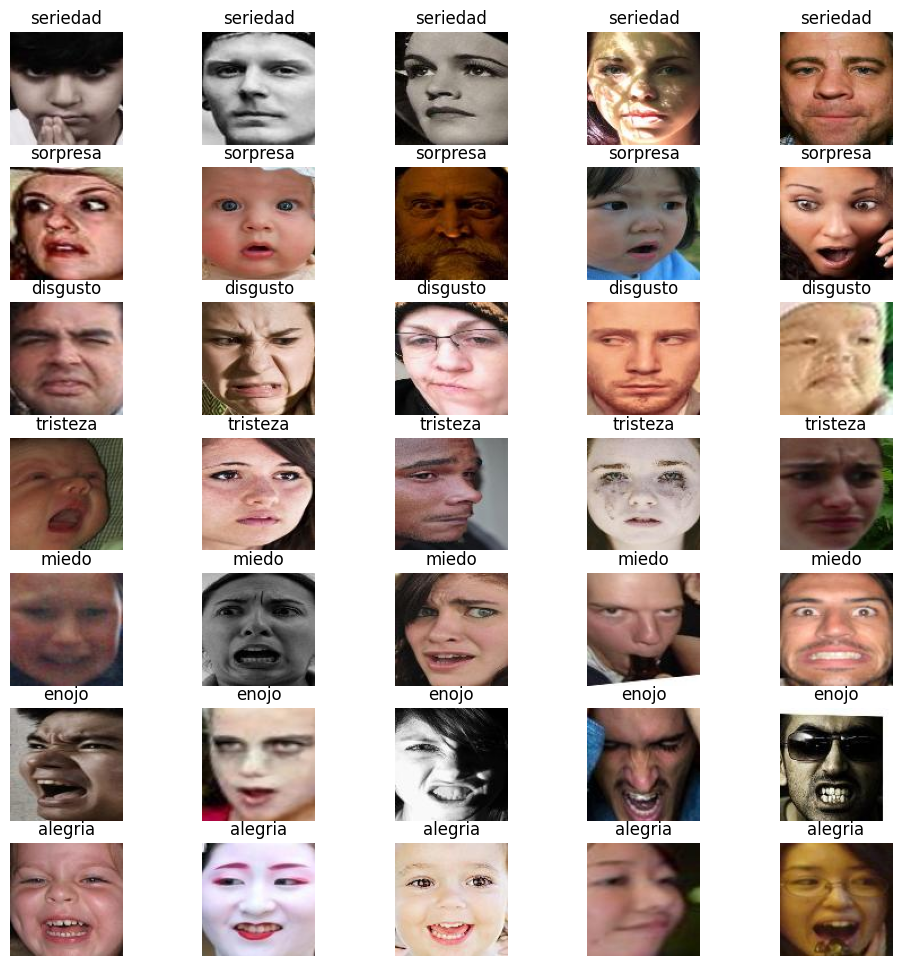

In [2]:
# Analisis exploratorio, imprimimos un par de imagenes por cada clase

DATA_PATH = 'dataset_emociones/train'

num_samples_to_show = 5
titles = list()
images = list()

for folder_name in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, folder_name)
    print(f"Exploring folder: {folder_path}")
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path)[:num_samples_to_show]:
            img_path = os.path.join(folder_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                titles.append(folder_name)
    
sv.plot_images_grid(images=images, titles=titles, grid_size=(len(set(titles)), num_samples_to_show))

Reestructuro el dataset para que sea mas manejable. Voy a crear un archivo csv con las etiquetas y paths
correspondientes a cada imagen, tanto para test como para train.

In [3]:
def is_image(file_name: str) -> bool:
    return file_name.lower().endswith(
        ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))    

def generate_image_csv(
    data_dir: str,
) -> pd.DataFrame:
    """
    Generate a CSV file with image paths and class labels.
    
    Parameters
    ----------
    data_dir:str
        Path to the root directory containing class-named folders of images.
    """
    data = []

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                if is_image(file_name=image_name):
                    data.append([os.path.join(class_path, image_name), class_name])
    return pd.DataFrame(data)

dataset_val = 'dataset_emociones/validation'
dataset_train = 'dataset_emociones/train'

df_train = generate_image_csv(data_dir=dataset_train)
df_val = generate_image_csv(data_dir=dataset_val)

df_train.to_csv('train.csv', index=False, header=False)
df_val.to_csv('validation.csv', index=False, header=False)

A partir de aca trabajamos con el dataset en el nuevo formato

7 classes in train dataset
7 classes in val dataset
Classes: ['seriedad' 'sorpresa' 'disgusto' 'tristeza' 'miedo' 'enojo' 'alegria']
Train dataset: 12271 images
Validation dataset: 3068 images
val / train ratio: 0.25 

Distribucion de clases en train 
-------------------------------
1
alegria     4772
seriedad    2524
tristeza    1982
sorpresa    1290
disgusto     717
enojo        705
miedo        281
Name: count, dtype: int64


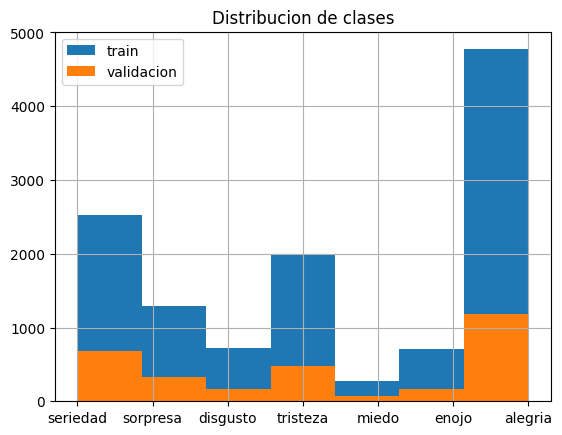

In [3]:
df_train = pd.read_csv('train.csv', header=None)
df_val = pd.read_csv('validation.csv', header=None)

print(f"{df_train[1].nunique()} classes in train dataset")
print(f"{df_val[1].nunique()} classes in val dataset")
print(f"Classes: {df_train[1].unique()}")
print(f"Train dataset: {len(df_train)} images")
print(f"Validation dataset: {len(df_val)} images")
print(f"val / train ratio: {len(df_val) / len(df_train):.2f} \n")

print("Distribucion de clases en train \n-------------------------------")
print(df_train[1].value_counts())

df_train[1].hist(bins=df_train[1].nunique())
df_val[1].hist(bins=df_val[1].nunique())
plt.title("Distribucion de clases")
plt.legend(["train", "validacion"])

In [4]:
# Define a weight vector for the loss function
class_weights = 1 / df_train[1].value_counts()
print(f"Weight vector for loss function: {class_weights}")

# sample weight per image
sample_weights = [class_weights[label] for label in df_train[1]]

Weight vector for loss function: 1
alegria     0.000210
seriedad    0.000396
tristeza    0.000505
sorpresa    0.000775
disgusto    0.001395
enojo       0.001418
miedo       0.003559
Name: count, dtype: float64


Vemos que el dataset contiene imagenes de 100x100 pixeles. Con un fuerte desbalance entre las clases, en especial para la clase "alegria", la
cual duplica en cantidad a la 2da clase mayoritaria (seriedad) y supera en un orden de magnitud a la minoritaria (miedo).
La distribucion de clases de validacion y train es proporcional entre ambos conjuntos, incluso se respeta el desbalance entre las clases mecionado arriba. Para corregir este problema se utilizara un data sampler que se inicializara con los pesos de cada clase, de forma que las clases minoritarias tengan mayor probabilidad de ser seleccionadas en cada batch. Para evitar repeticion de imagenes durante el sobremuestreo se aplican tecnicas de aumeto de datos como espejado aleatorio y ligeras modificaciones de color. 


In [41]:
# Dataset y dataloader

class ImgClassificationDataset(Dataset):

    IMG_CLASS_COL = 1

    def __init__(self, dataset_csv:str, transform=None):
        """
        Parameters
        ----------
        dataset_csv:str
            Path to a csv file contaning image name and class labels
        """
        super().__init__()

        self.transform = transform
        self._dataset_df = pd.read_csv(dataset_csv, header=None)
        self.labels = list(set(self._dataset_df[self.IMG_CLASS_COL]))
        self.label2id = {label:i for i, label in enumerate(self.labels)}
        self.id2label = {i:label for i, label in enumerate(self.labels)}

    def __getitem__(self, index):
        # store as attributes for further usage
        self.image_path, self.class_name = self._dataset_df.loc[index]
        image_bgr = cv2.imread(self.image_path)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        if self.transform:
            image_rgb = self.transform(image_rgb)
        return image_rgb, self.label2id[self.class_name]

    def __len__(self):
        return len(self._dataset_df)

transforms = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    v2.Resize((224, 224)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize((224, 224)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImgClassificationDataset(
    dataset_csv='train.csv', transform=transforms)
val_dataset = ImgClassificationDataset(
    dataset_csv='validation.csv', transform=val_transforms)

sampler = WeightedRandomSampler(weights=sample_weights,
                                num_samples=len(train_dataset),
                                replacement=True)

BATCH_SIZE = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

/home/maxim/anaconda3/envs/SV_analytics/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Para el modelo se va a adoptar una arquitectura ResNet18, con lo cual el procesamiento aplicado al dataset se corresponde con el que fue utilizado en el trabajo [Going Deeper With Convolutions](https://arxiv.org/pdf/1409.4842). Se aplica la misma normalizacion que en Imagenet pero esto es solo para ser consistente con el paper, ya que las imagenes no son de ese dataset y el modelo se entrena desde cero sin transfer learning.

## 2. Construcción y entrenamiento del Modelo CNN (3.5 puntos)

- Construir una red neuronal convolucional desde cero, sin usar modelos pre-entrenados.
- Analizar correctamente qué funciones de activación se deben usar en cada etapa de la red, el learning rate a utilizar, la función de costo y el optimizador.
- Cosas como el número de capas, neuronas, tanaño de kernel, entre otros, queda a criterio de ustedes, pero deben estar justificadas.

Se implementa la arquitectura de ResNet18 siguiendo el paper [Going Deeper With Convolutions](https://arxiv.org/pdf/1409.4842).

In [33]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, intermediate_channels, stride):
        
        """
        Creates a residual block that adds the input feature maps to the output
        feature maps of the block.
        
        Parameters
        ----------
        in_channels : int
            Number of input channels to the block
        intermediate_channels : int
            Number of channels in the intermediate convolution layers
        stride : int
            Stride for the convolution layers in the block
        """

        super(ResBlock, self).__init__()

        self.in_channels = in_channels
        self.intermediate_channels = intermediate_channels
        
        # i.e. if dim(x) == dim(F) => Identity function
        if self.in_channels == self.intermediate_channels:
            self.identity = True
        else:
            self.identity = False
            projection_layer = []
            projection_layer.append(nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=1, stride=stride, padding=0, bias=False ))
            projection_layer.append(nn.BatchNorm2d(self.intermediate_channels))
            # Only conv->BN and no ReLU
            # projection_layer.append(nn.ReLU())
            self.projection = nn.Sequential(*projection_layer)

        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(
            in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False )
        self.batchnorm1 = nn.BatchNorm2d(self.intermediate_channels)
            
        self.conv2 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=1, padding=1, bias=False )
        self.batchnorm2 = nn.BatchNorm2d(self.intermediate_channels)

    def forward(self, x):
        
        in_x = x # save to be summed at the output

        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.batchnorm2(self.conv2(x))
        # identity or projected mapping
        if self.identity:
            x += in_x
        else:
            x += self.projection(in_x)
        x = self.relu(x)
        
        return x


class ResNet18(nn.Module):

    def __init__(
        self, 
        num_classes: int, 
        in_channels: int = 3
    ):
        """
        ResNet18 architecture modelization.

        Parameters
        ----------
        num_classes : int
            Number of classes for the classification head
        in_channels : int
            Number of input channels, by default 3 (RGB images)
        """
        super(ResNet18, self).__init__()
        self.channels_list = [64, 128, 256, 512] # resnet filters per layer
        self.repetition_list = [2, 2, 2, 2] # block repetition per layer

        # First conv block at the network input. This block never repeats.
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Create residual blocks 
        self.block1 = self._make_blocks(64, self.channels_list[0], self.repetition_list[0], stride=1 )
        self.block2 = self._make_blocks(self.channels_list[0], self.channels_list[1], self.repetition_list[1], stride=2)
        self.block3 = self._make_blocks(self.channels_list[1], self.channels_list[2], self.repetition_list[2], stride=2)
        self.block4 = self._make_blocks(self.channels_list[2], self.channels_list[3], self.repetition_list[3], stride=2)

        # Output block with classification head
        self.average_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(self.channels_list[3], num_classes)

    def forward(self,x):

        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = self.average_pool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        
        return x

    def _make_blocks(
        self,
        in_channels,
        intermediate_channels, 
        num_repeat, 
        stride):
        
        """
        Create a sequence of residual blocks.

        Parameters
        ----------
        in_channels : int
            Number of input channels to the first block
        intermediate_channels : int
            Number of channels in the intermediate convolution layers
        num_repeat : int
            Number of residual blocks to create in the sequence
        """
        layers = [] 

        layers.append(ResBlock(in_channels, intermediate_channels, stride=stride))
        for _ in range(1, num_repeat):
            layers.append(ResBlock(intermediate_channels, intermediate_channels, stride=1))

        return nn.Sequential(*layers)

In [42]:
model = ResNet18(num_classes=len(train_dataset.label2id))
torchinfo.summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [1, 7]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,472
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─ResBlock: 2-1                     [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [43]:
def compute_metrics(
    model: nn.Module, 
    data: DataLoader, 
    loss_fn: Optional[Callable] = None
) -> Tuple[float, float, Optional[float]]:
    """
    Evaluates the model on the given data loader. Computes accuracy, f1 score 
    and loss (if loss_fn is provided).
    
    Parameters
    ----------
    model: nn.Module
        The PyTorch model to evaluate.
    data: DataLoader
        The DataLoader containing the dataset to evaluate on.
    loss_fn: Optional[Callable]:
        Loss function to compute loss, if None, loss is not computed.
        
    Returns
    -------
    accuracy: float
        Accuracy score of the model on the dataset.
    f1_score: float
        F1 score of the model on the dataset.
    loss: Optional[float]
        Loss value if loss_fn is provided, otherwise None.
    """
    loss = 0
    y_true = list()
    y_pred = list()
    batch_count = 0

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(data):

            batch_count += 1
            outputs = model(images.to('cuda'))
            _, preds = torch.max(outputs, 1)
            y_true.extend(val_dataset.id2label[label] for label in labels.numpy())
            y_pred.extend(val_dataset.id2label[pred] for pred in preds.cpu().numpy())
            if loss_fn is not None:
                loss += loss_fn(outputs, labels.cuda()).item()

    loss = loss / batch_count if loss_fn is not None else None

    f1 = f1_score(
        y_true=y_true, 
        y_pred=y_pred, 
        average='weighted')  # weighted average to consider class imbalance

    accuracy = accuracy_score(
        y_true=y_true, 
        y_pred=y_pred)

    return accuracy, f1, loss

Para el entrenamiento se utiliza el optimizador Adam con un learning rate inicial de 0.001, y se entrena durante 50 epochs. La funcion de perdida utilizada es CrossEntropyLoss, la cual es adecuada para problemas de clasificacion multiclase como este. Se utiliza ademas un learning rate scheduler para
modificar el learning rate durante el entrenamiento, reduciendolo un 10% si el accuracy de validacion no mejora durante 5 epochs. Para cada mejora en el accuracy de validacion se guarda el modelo en un archivo .pth, de forma que se pueda recuperar el mejor modelo al finalizar el entrenamiento.

In [44]:
EPOCHS = 50
LR = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=5, mode='max', threshold=0.001)
model.to('cuda' if torch.cuda.is_available() else 'cpu')

train_loss_avg = list()
train_accuracy = list()
train_f1 = list()

val_loss = list()
val_accuracy = list()
val_f1 = list()

max_val_accuracy = 0

for epoch in range(EPOCHS):
    model.train()

    y_pred = list()
    y_true = list()

    train_loss_avg.append(0)

    batch_count = 0
    for images, labels in tqdm(train_loader):

        batch_count += 1
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        train_loss_avg[-1] += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Append predictions and true labels for train metrics computation
        _, preds = torch.max(outputs, 1)
        y_true.extend(train_dataset.id2label[label] for label in labels.cpu().numpy())
        y_pred.extend(train_dataset.id2label[pred] for pred in preds.cpu().numpy())

    ########### Evaluation phase ###########

    # Eval on training set
    train_loss_avg[-1] /= batch_count
    train_accuracy.append(
        accuracy_score(y_true=y_true, y_pred=y_pred))
    train_f1.append(f1_score(
        y_true=y_true, 
        y_pred=y_pred, 
        average='weighted'))  # wheighted average to consider class imbalance

    # Eval on validation set
    val_accuracy_epoch, val_f1_epoch, val_loss_epoch = compute_metrics(
        model=model, data=val_loader, loss_fn=loss_fn)

    # save model if accuracy improves:
    if epoch == 0 or val_accuracy_epoch > max_val_accuracy:
        print(
            f'Val acc improved from {max_val_accuracy} to {val_accuracy_epoch}, saving model at epoch {epoch+1}')
        torch.save(model.state_dict(), 'resnet18_best.pth')
        max_val_accuracy = val_accuracy_epoch

    val_loss.append(val_loss_epoch)
    val_accuracy.append(val_accuracy_epoch)
    val_f1.append(val_f1_epoch)

    # Step the learning rate scheduler
    lr_scheduler.step(metrics=val_accuracy_epoch)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}]: Train Loss avg: {train_loss_avg[-1]:.4f} Val loss: {val_loss[-1]:.4f}")
    print(
        f"Train Acc: {train_accuracy[-1]:.4f} Val Acc: {val_accuracy[-1]:.4f}")


100%|██████████| 48/48 [00:03<00:00, 14.31it/s]


Val acc improved from 0 to 0.14634941329856585, saving model at epoch 1
Epoch [1/50]: Train Loss avg: 1.9198 Val loss: 2.1548
Train Acc: 0.2285 Val Acc: 0.1463


100%|██████████| 48/48 [00:03<00:00, 14.32it/s]


Val acc improved from 0.14634941329856585 to 0.30345501955671444, saving model at epoch 2
Epoch [2/50]: Train Loss avg: 1.8206 Val loss: 3.5837
Train Acc: 0.2716 Val Acc: 0.3035


100%|██████████| 48/48 [00:03<00:00, 14.39it/s]


Val acc improved from 0.30345501955671444 to 0.4791395045632334, saving model at epoch 3
Epoch [3/50]: Train Loss avg: 1.5482 Val loss: 1.3890
Train Acc: 0.4066 Val Acc: 0.4791


100%|██████████| 48/48 [00:03<00:00, 14.58it/s]


Val acc improved from 0.4791395045632334 to 0.5319426336375489, saving model at epoch 4
Epoch [4/50]: Train Loss avg: 1.2262 Val loss: 1.3325
Train Acc: 0.5521 Val Acc: 0.5319


100%|██████████| 48/48 [00:03<00:00, 14.23it/s]


Epoch [5/50]: Train Loss avg: 1.0265 Val loss: 1.4605
Train Acc: 0.6220 Val Acc: 0.4821


100%|██████████| 48/48 [00:03<00:00, 15.09it/s]


Epoch [6/50]: Train Loss avg: 0.8450 Val loss: 1.6280
Train Acc: 0.6924 Val Acc: 0.5010


100%|██████████| 48/48 [00:03<00:00, 13.83it/s]


Val acc improved from 0.5319426336375489 to 0.6541720990873533, saving model at epoch 7
Epoch [7/50]: Train Loss avg: 0.6894 Val loss: 0.9507
Train Acc: 0.7482 Val Acc: 0.6542


100%|██████████| 48/48 [00:03<00:00, 14.77it/s]


Val acc improved from 0.6541720990873533 to 0.6649282920469362, saving model at epoch 8
Epoch [8/50]: Train Loss avg: 0.5745 Val loss: 0.9355
Train Acc: 0.7928 Val Acc: 0.6649


100%|██████████| 48/48 [00:03<00:00, 15.09it/s]


Val acc improved from 0.6649282920469362 to 0.6988265971316818, saving model at epoch 9
Epoch [9/50]: Train Loss avg: 0.4766 Val loss: 0.8705
Train Acc: 0.8275 Val Acc: 0.6988


100%|██████████| 48/48 [00:03<00:00, 13.97it/s]


Epoch [10/50]: Train Loss avg: 0.4118 Val loss: 0.9533
Train Acc: 0.8504 Val Acc: 0.6877


100%|██████████| 48/48 [00:03<00:00, 13.82it/s]


Epoch [11/50]: Train Loss avg: 0.3519 Val loss: 0.9822
Train Acc: 0.8758 Val Acc: 0.6858


100%|██████████| 48/48 [00:03<00:00, 14.89it/s]


Epoch [12/50]: Train Loss avg: 0.2861 Val loss: 1.0837
Train Acc: 0.8995 Val Acc: 0.6832


100%|██████████| 48/48 [00:03<00:00, 14.65it/s]


Val acc improved from 0.6988265971316818 to 0.741199478487614, saving model at epoch 13
Epoch [13/50]: Train Loss avg: 0.2536 Val loss: 0.9017
Train Acc: 0.9122 Val Acc: 0.7412


100%|██████████| 48/48 [00:03<00:00, 14.71it/s]


Epoch [14/50]: Train Loss avg: 0.2212 Val loss: 1.1213
Train Acc: 0.9236 Val Acc: 0.6861


100%|██████████| 48/48 [00:03<00:00, 14.73it/s]


Val acc improved from 0.741199478487614 to 0.7522816166883963, saving model at epoch 15
Epoch [15/50]: Train Loss avg: 0.1929 Val loss: 0.9002
Train Acc: 0.9324 Val Acc: 0.7523


100%|██████████| 48/48 [00:03<00:00, 14.72it/s]


Epoch [16/50]: Train Loss avg: 0.1796 Val loss: 1.0061
Train Acc: 0.9355 Val Acc: 0.7344


100%|██████████| 48/48 [00:03<00:00, 14.49it/s]


Val acc improved from 0.7522816166883963 to 0.758800521512386, saving model at epoch 17
Epoch [17/50]: Train Loss avg: 0.1499 Val loss: 0.9976
Train Acc: 0.9478 Val Acc: 0.7588


100%|██████████| 48/48 [00:03<00:00, 14.46it/s]


Epoch [18/50]: Train Loss avg: 0.1531 Val loss: 0.9607
Train Acc: 0.9461 Val Acc: 0.7559


100%|██████████| 48/48 [00:03<00:00, 14.85it/s]


Epoch [19/50]: Train Loss avg: 0.1493 Val loss: 0.9527
Train Acc: 0.9479 Val Acc: 0.7477


100%|██████████| 48/48 [00:03<00:00, 14.63it/s]


Val acc improved from 0.758800521512386 to 0.7754237288135594, saving model at epoch 20
Epoch [20/50]: Train Loss avg: 0.1082 Val loss: 0.9343
Train Acc: 0.9625 Val Acc: 0.7754


100%|██████████| 48/48 [00:03<00:00, 14.33it/s]


Epoch [21/50]: Train Loss avg: 0.1102 Val loss: 1.0128
Train Acc: 0.9636 Val Acc: 0.7683


100%|██████████| 48/48 [00:03<00:00, 14.71it/s]


Epoch [22/50]: Train Loss avg: 0.0922 Val loss: 0.9983
Train Acc: 0.9680 Val Acc: 0.7568


100%|██████████| 48/48 [00:03<00:00, 14.72it/s]


Epoch [23/50]: Train Loss avg: 0.0935 Val loss: 1.0277
Train Acc: 0.9680 Val Acc: 0.7712


100%|██████████| 48/48 [00:03<00:00, 14.86it/s]


Epoch [24/50]: Train Loss avg: 0.0790 Val loss: 1.0611
Train Acc: 0.9718 Val Acc: 0.7601


100%|██████████| 48/48 [00:03<00:00, 14.80it/s]


Epoch [25/50]: Train Loss avg: 0.0999 Val loss: 1.0453
Train Acc: 0.9667 Val Acc: 0.7709


100%|██████████| 48/48 [00:03<00:00, 14.33it/s]


Val acc improved from 0.7754237288135594 to 0.7819426336375489, saving model at epoch 26
Epoch [26/50]: Train Loss avg: 0.0770 Val loss: 0.9866
Train Acc: 0.9744 Val Acc: 0.7819


100%|██████████| 48/48 [00:03<00:00, 14.60it/s]


Epoch [27/50]: Train Loss avg: 0.0705 Val loss: 1.0322
Train Acc: 0.9749 Val Acc: 0.7731


100%|██████████| 48/48 [00:03<00:00, 14.47it/s]


Epoch [28/50]: Train Loss avg: 0.0577 Val loss: 1.2862
Train Acc: 0.9822 Val Acc: 0.7229


100%|██████████| 48/48 [00:03<00:00, 14.44it/s]


Epoch [29/50]: Train Loss avg: 0.0633 Val loss: 1.1372
Train Acc: 0.9773 Val Acc: 0.7624


100%|██████████| 48/48 [00:03<00:00, 14.58it/s]


Epoch [30/50]: Train Loss avg: 0.0682 Val loss: 1.1679
Train Acc: 0.9757 Val Acc: 0.7630


100%|██████████| 48/48 [00:03<00:00, 13.43it/s]


Epoch [31/50]: Train Loss avg: 0.0651 Val loss: 1.1988
Train Acc: 0.9762 Val Acc: 0.7598


100%|██████████| 48/48 [00:03<00:00, 13.72it/s]


Epoch [32/50]: Train Loss avg: 0.0679 Val loss: 1.1237
Train Acc: 0.9773 Val Acc: 0.7673


100%|██████████| 48/48 [00:03<00:00, 14.79it/s]


Val acc improved from 0.7819426336375489 to 0.7913950456323338, saving model at epoch 33
Epoch [33/50]: Train Loss avg: 0.0266 Val loss: 1.0336
Train Acc: 0.9911 Val Acc: 0.7914


100%|██████████| 48/48 [00:03<00:00, 14.73it/s]


Val acc improved from 0.7913950456323338 to 0.7985658409387223, saving model at epoch 34
Epoch [34/50]: Train Loss avg: 0.0168 Val loss: 1.0270
Train Acc: 0.9956 Val Acc: 0.7986


100%|██████████| 48/48 [00:03<00:00, 14.69it/s]


Epoch [35/50]: Train Loss avg: 0.0120 Val loss: 1.0247
Train Acc: 0.9970 Val Acc: 0.7969


100%|██████████| 48/48 [00:03<00:00, 14.74it/s]


Epoch [36/50]: Train Loss avg: 0.0107 Val loss: 1.0293
Train Acc: 0.9972 Val Acc: 0.7976


100%|██████████| 48/48 [00:03<00:00, 14.97it/s]


Val acc improved from 0.7985658409387223 to 0.8001955671447197, saving model at epoch 37
Epoch [37/50]: Train Loss avg: 0.0085 Val loss: 1.0298
Train Acc: 0.9981 Val Acc: 0.8002


100%|██████████| 48/48 [00:03<00:00, 14.41it/s]


Epoch [38/50]: Train Loss avg: 0.0069 Val loss: 1.0466
Train Acc: 0.9990 Val Acc: 0.7995


100%|██████████| 48/48 [00:03<00:00, 13.94it/s]


Epoch [39/50]: Train Loss avg: 0.0061 Val loss: 1.0432
Train Acc: 0.9986 Val Acc: 0.8002


100%|██████████| 48/48 [00:03<00:00, 14.28it/s]


Val acc improved from 0.8001955671447197 to 0.8011734028683182, saving model at epoch 40
Epoch [40/50]: Train Loss avg: 0.0053 Val loss: 1.0484
Train Acc: 0.9988 Val Acc: 0.8012


100%|██████████| 48/48 [00:03<00:00, 14.81it/s]


Val acc improved from 0.8011734028683182 to 0.8047588005215124, saving model at epoch 41
Epoch [41/50]: Train Loss avg: 0.0047 Val loss: 1.0641
Train Acc: 0.9991 Val Acc: 0.8048


100%|██████████| 48/48 [00:03<00:00, 14.63it/s]


Epoch [42/50]: Train Loss avg: 0.0049 Val loss: 1.0704
Train Acc: 0.9986 Val Acc: 0.8008


100%|██████████| 48/48 [00:03<00:00, 14.65it/s]


Epoch [43/50]: Train Loss avg: 0.0039 Val loss: 1.0732
Train Acc: 0.9994 Val Acc: 0.8005


100%|██████████| 48/48 [00:03<00:00, 14.48it/s]


Epoch [44/50]: Train Loss avg: 0.0030 Val loss: 1.0786
Train Acc: 0.9998 Val Acc: 0.8015


100%|██████████| 48/48 [00:03<00:00, 14.19it/s]


Epoch [45/50]: Train Loss avg: 0.0035 Val loss: 1.0823
Train Acc: 0.9995 Val Acc: 0.8002


100%|██████████| 48/48 [00:03<00:00, 14.61it/s]


Val acc improved from 0.8047588005215124 to 0.8057366362451108, saving model at epoch 46
Epoch [46/50]: Train Loss avg: 0.0031 Val loss: 1.1146
Train Acc: 0.9995 Val Acc: 0.8057


100%|██████████| 48/48 [00:03<00:00, 14.89it/s]


Epoch [47/50]: Train Loss avg: 0.0027 Val loss: 1.0964
Train Acc: 0.9998 Val Acc: 0.8051


100%|██████████| 48/48 [00:03<00:00, 15.00it/s]


Epoch [48/50]: Train Loss avg: 0.0025 Val loss: 1.1142
Train Acc: 0.9996 Val Acc: 0.8025


100%|██████████| 48/48 [00:03<00:00, 14.66it/s]


Epoch [49/50]: Train Loss avg: 0.0031 Val loss: 1.1115
Train Acc: 0.9994 Val Acc: 0.7943


100%|██████████| 48/48 [00:03<00:00, 14.77it/s]

Epoch [50/50]: Train Loss avg: 0.0025 Val loss: 1.1246
Train Acc: 0.9997 Val Acc: 0.7999


In [48]:
model = ResNet18(num_classes=7)
model.load_state_dict(torch.load('resnet18_best.pth'))
model.cuda()

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (block1): Sequential(
    (0): ResBlock(
      (relu): ReLU()
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (relu): ReLU()
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64

## 3. Evaluación del Modelo (2.5 puntos)

El modelo entrenado debe ser evaluado utilizando las siguientes métricas:

- **Accuracy**:
  - Reportar el valor final en el conjunto de validación.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **F1 Score**:
  - Reportar el valor final en el conjunto de validación.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **Costo (Loss)**:
  - Mostrar una gráfica de evolución del costo por época para entrenamiento y validación.

- **Classification report**
  - Mostrar la precisión, recall y F1 score por cada clase usando `classification_report`

- **Matriz de confusión**:
  - Mostrar la matriz de confusión absoluta (valores enteros).
  - Mostrar la matriz de confusión normalizada (valores entre 0 y 1 por fila).

Se recomienda utilizar `scikit-learn` para calcular métricas como accuracy, F1 score, el Classification report y las matrices de confusión. Las visualizaciones pueden realizarse con `matplotlib` o `seaborn`, separando claramente los datos de entrenamiento y validación en las gráficas.


In [49]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images = images.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predicted = predicted.cpu()

        y_true.extend(val_dataset.id2label[label] for label in labels.numpy())
        y_pred.extend(val_dataset.id2label[pred] for pred in predicted.cpu().numpy())

100%|██████████| 48/48 [00:03<00:00, 14.05it/s]


Accuracy and F1

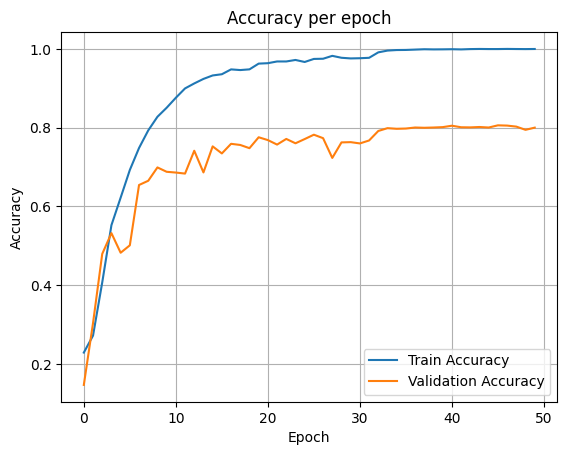

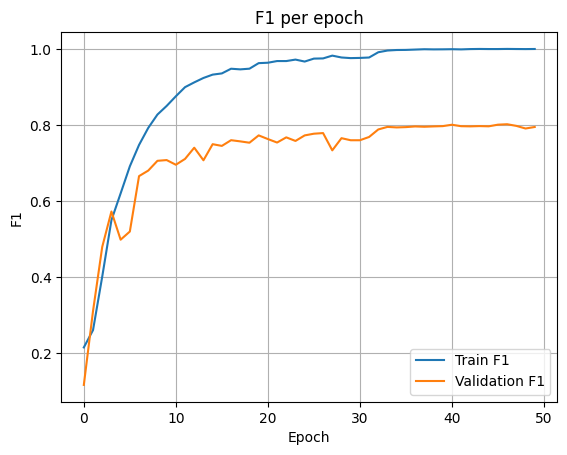

In [59]:
plt.plot(range(EPOCHS), train_accuracy, label='Train Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.title("Accuracy per epoch")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid('minor')
plt.show()

plt.plot(range(EPOCHS), train_f1, label='Train F1')
plt.plot(range(EPOCHS), val_f1, label='Validation F1')
plt.title("F1 per epoch")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.grid('minor')
plt.show()

Loss

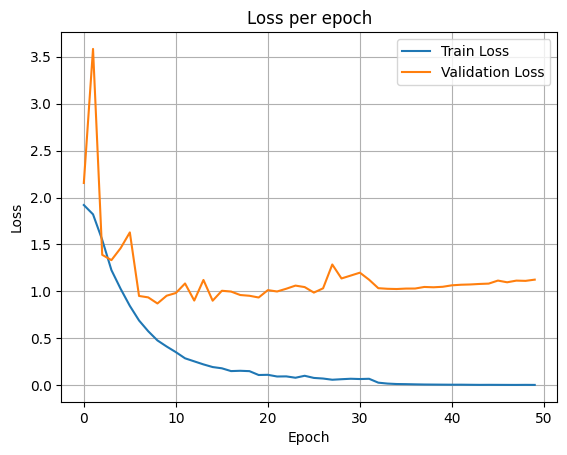

In [60]:
plt.plot(range(EPOCHS), train_loss_avg, label='Train Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title("Loss per epoch")
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid('minor')

Vemos que todas las graficas tienen un comportamiento esperado mostrando metricas de validacion ligeramente inferiores que las de entrenamiento, lo cual es normal. El accuracy y F1 score muestran una tendencia creciente durante el entrenamiento, con un estancamiento en las ultimas epochs.

              precision    recall  f1-score   support

    disgusto       0.90      0.91      0.91      1185
    sorpresa       0.64      0.39      0.48       160
     alegria       0.72      0.68      0.70       162
       enojo       0.70      0.42      0.53        74
    seriedad       0.74      0.84      0.79       680
    tristeza       0.79      0.80      0.79       329
       miedo       0.76      0.74      0.75       478

    accuracy                           0.81      3068
   macro avg       0.75      0.68      0.71      3068
weighted avg       0.80      0.81      0.80      3068



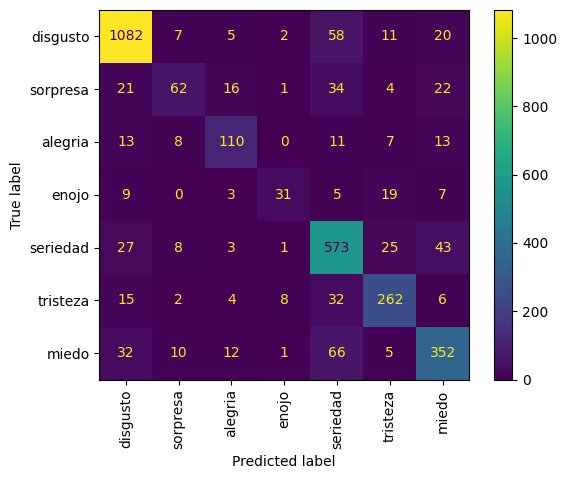

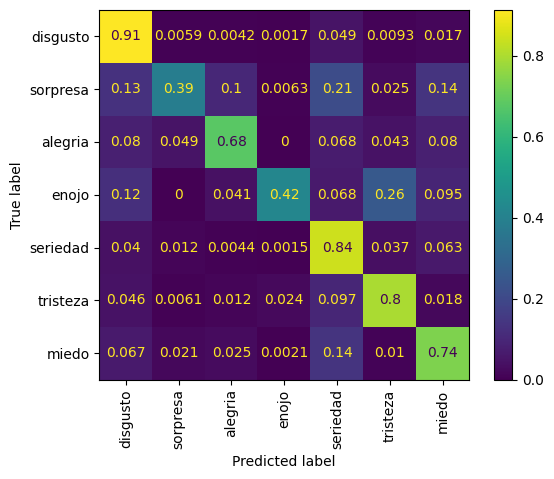

In [52]:
print(classification_report(y_true, y_pred, target_names=val_dataset.labels))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=val_dataset.labels, xticks_rotation='vertical')
plt.show()
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=val_dataset.labels, xticks_rotation='vertical', normalize='true')
plt.show()

 ## 4. Prueba de Imágenes Nuevas (1 punto)
Subir al menos 5 imágenes personales de cualquier relación de aspecto (pueden usar fotos del rostro de ustedes, rostros de personas generadas por IA o imágenes stock de internet), que no formen parte del dataset de entrenamiento ni de validación.

- Cada imagen debe representar una emoción distinta.

- Aplicar el mismo pre-procesamiento que se usó para el dataset durante el entrenamiento del modelo.

- Pasar las imágenes por el modelo entrenado y mostrar:

  - La imagen original
  - La imagen pre-procesada (mismas transformaciones del entrenamiento)
  - El score asignado a cada clase
  - La clase ganadora inferida por el modelo

- Redactar conclusiones preliminares

Imagenes originales y pre-procesadas

/home/maxim/anaconda3/envs/SV_analytics/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


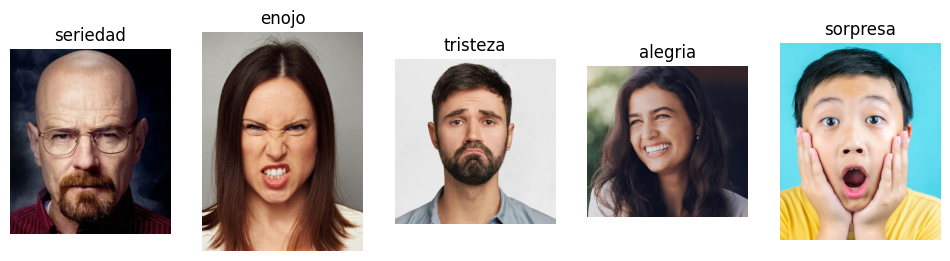

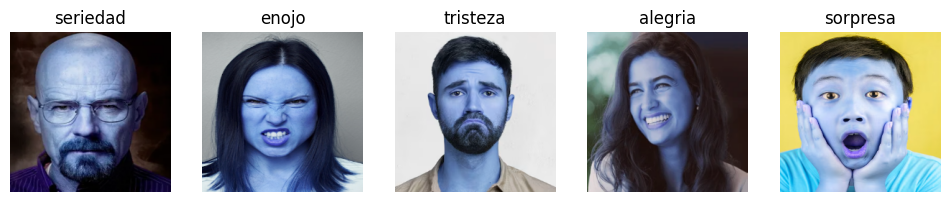

In [53]:
transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize((224, 224)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

TEST_DATA = './test_faces'
images = list()
labels = list()

for img_file in os.listdir(TEST_DATA):
    if is_image(file_name=img_file):
        img_bgr = cv2.imread(os.path.join(TEST_DATA, img_file))
        images.append(img_bgr)
        labels.append(img_file.split('.')[0])

# Excluimos la normalizacion y el pasaje a tensor ya que necesitamos las
# imagenes con tipo de dato uint8 para visualizarlas. Solo uncluimos el resize
# y el cambio de color a RGB que se aplica en nuestra clase Dataset.
images_preproc = [cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), dsize=(224, 224)) for img in images]

sv.plot_images_grid(images=images, titles=labels, grid_size=(1, len(set(labels))))
sv.plot_images_grid(images=images_preproc, titles=labels, grid_size=(1, len(set(labels))))

Al cambiar el orden de los canales la biblioteca de visualizacion interpreta mal los colores, se excluyo la normalizacion del procesamiento ya que esto haria que las imagenes no se visualicen correctamente, estas deben estar en uint8 para poder ser mostradas.

In [54]:
input_tensors = [transforms(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) for img in images]
input_tensors = torch.stack(input_tensors).to('cuda')
model.eval()
with torch.no_grad():
    outputs = model(input_tensors)
    all_scores = torch.nn.functional.softmax(outputs, dim=1)
    _, preds = torch.max(outputs, 1)
    scores, _ = torch.max(all_scores, 1)

preds = preds.cpu().numpy()
scores = scores.cpu().numpy()
predicted_labels = [val_dataset.id2label[pred] for pred in preds]

print(f"Predicted labels: {predicted_labels}")
print(f"Scores: {scores}")

Predicted labels: ['sorpresa', 'alegria', 'tristeza', 'seriedad', 'sorpresa']
Scores: [0.9915554  0.9979741  0.7593161  0.81038266 0.99989605]


### Conclusiones preliminares

Las imagenes elegidas presentan diferentes relaciones de aspecto y poseen mas "fondo" que las del dataset, estas ultimas contienen una roi con la cara ocupando la totalidad de la imagen lo que hace que el modelo no pueda identificar correctamente la emocion en ciertos casos. Vemos que la probabilidad asignada a la clase ganadora en las imagenes 2 y 3 es mas baja que en el resto. Se clasifico correctamente 2 de las 5 imagenes, lo que no es un resultado alentador pero es esperable dado que el modelo no fue entrenado con imagenes de este tipo.

 ## 5. Prueba de Imágenes Nuevas con Pre-procesamiento Adicional (1 punto)
Las 5 imágenes del punto 4, ahora serán pasadas y recortadas por un algoritmo de detección de rostros. Usen el siguiente código para realizar un pre-procesamiento inicial de la imagen y ya luego aplican el pre-procesamiento que usaron al momento de entrenar el modelo.

- Pasar las imágenes por el modelo entrenado y mostrar:
  - La imagen original
  - La imagen recortada por el algoritmo
  - La imagen pre-procesada (mismas transformaciones del entrenamiento)
  - El score asignado a cada clase
  - La clase ganadora inferida por el modelo

- Comparar los resultados con el punto 4 y redactar conclusiones finales.

NOTA: Pueden adaptar el código según crean conveniente para obtener mejores resultados.

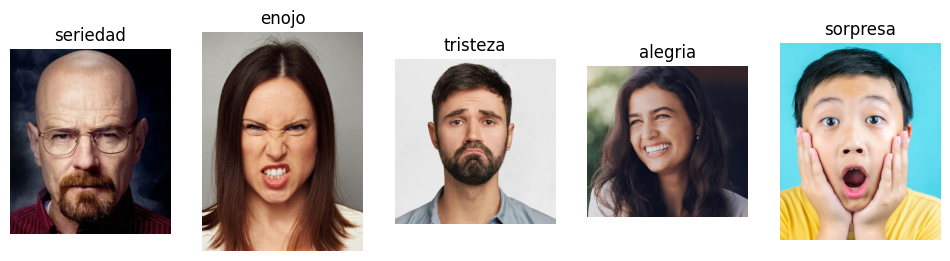

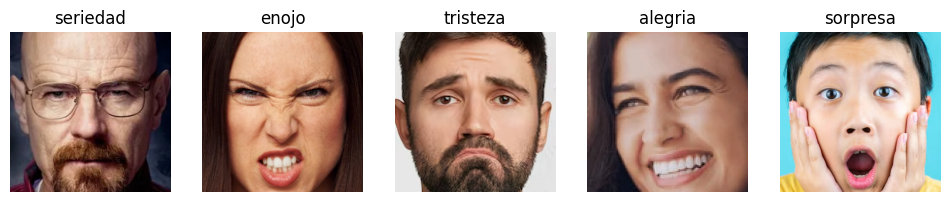

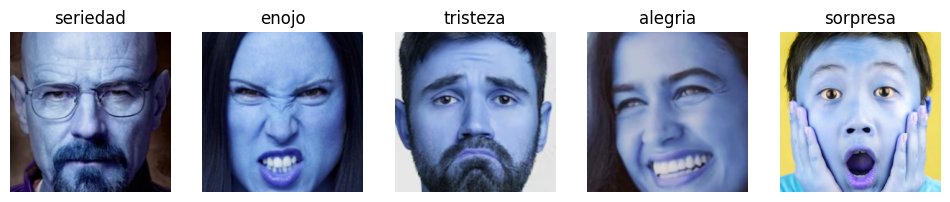

In [57]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

cropped_faces = list()

for image in images:

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6)

    image_with_box = image.copy()
    for (x, y, w, h) in faces:
        cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cropped_face_rgb = None
    if len(faces) > 0:
        (x, y, w, h) = faces[0]
        center_x, center_y = x + w // 2, y + h // 2
        side = max(w, h)
        half_side = side // 2

        x1 = max(center_x - half_side, 0)
        y1 = max(center_y - half_side, 0)
        x2 = min(center_x + half_side, image.shape[1])
        y2 = min(center_y + half_side, image.shape[0])

        cropped_face = image[y1:y2, x1:x2]
        cropped_faces.append(cropped_face)
    else:
        # Si no se detecto rosto agregamos la imagen original para procesar en orden
        cropped_faces.append(image)

images_preproc = [cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), dsize=(224, 224)) for img in cropped_faces]

sv.plot_images_grid(images=images, titles=labels, grid_size=(1, len(set(labels))))
sv.plot_images_grid(images=cropped_faces, titles=labels, grid_size=(1, len(set(labels))))
sv.plot_images_grid(images=images_preproc, titles=labels, grid_size=(1, len(set(labels))))

In [58]:
input_tensors = [transforms(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) for img in cropped_faces]
input_tensors = torch.stack(input_tensors).to('cuda')
model.eval()
with torch.no_grad():
    outputs = model(input_tensors)
    all_scores = torch.nn.functional.softmax(outputs, dim=1)
    _, preds = torch.max(outputs, 1)
    scores, _ = torch.max(all_scores, 1)

preds = preds.cpu().numpy()
scores = scores.cpu().numpy()
predicted_labels = [val_dataset.id2label[pred] for pred in preds]

print(f"Predicted labels: {predicted_labels}")
print(f"Scores: {scores}")

Predicted labels: ['tristeza', 'enojo', 'tristeza', 'tristeza', 'sorpresa']
Scores: [0.82434094 0.76191646 0.9997708  0.62290186 0.99983776]


### Comparacion de resultados y conclusiones

Las imagenes recortadas por el algoritmo de deteccion de rostros permiten al modelo identificar mejor las emociones, ya que se eliminan los fondos y se centra en la cara. En este caso, el modelo logra clasificar correctamente 3 de las 5 imagenes, presentando scores mas altos a diferencia del caso anterior. La imagen 1 que antes se clasificaba como `sorpresa` ahora es clasificada como `tristeza` , si bien es incorrecto, ya que la idea era representar `seriedad` en realidad es un atributo que podria atribuirse a esa imagen. Esto se debe a que las emociones son subjetivas y pueden variar de persona a persona, por lo que el modelo puede no ser capaz de generalizar correctamente estos casos de borde.